# Forest Land Area (percentage of total land area)
In this notebook we will predict forest land area based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure.

Data cleaning: 
- Cleaning and assessing forest data 
- Combining forest data with Predictor data
- Imputing variables and removing NaN countries 
- Lagging the forest area percentage variable  

Data exploration:
- Exploring correlations with the predictor data 
- Checking for outliers 

Data splitting 
- Splitting the combined dataset in training, validation and testing data
- Checking whether the training split data is a representative sample and not confined to one area of the world.

Data modelling, linear regression:

- Mixed effect linear regression base line models
    - Fitting baseline model (mean model)
    - Fitting simple mixed effects model (time, population)
    
- Mixed effect linear regression theory driven models (social)
    - Social theory driven model 
    - Full social model 

- Mixed effect linear regression theory driven models (governance)
    - Governance theory drive model 
    - Full governance model

Data modelling, random forest:

- Mixed effect random forest social model 
- Mixed effect random forest governance model 
- Mixed effect all predictor model

Model comparison: 
- Compare model predictions 


# Data cleaning

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Read file 
df = pd.read_csv('Data/forest_area_percent.csv', skiprows=4)

Removing: 
- columns with 0 counts (keeping from 1990-2021)
- non-iso countries

In [4]:
#Remove columns with 0 counts
summary = df.describe()

count_row = summary.loc['count']

columns_with_zero_count = count_row[count_row == 0.0].index.tolist()

df_90 = df.drop(columns=columns_with_zero_count)

display(df_90)

,Country Name,Country Code,Indicator Name,Indicator Code,1990,1991,1992,1993,1994,1995,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,Forest area (% of land area),AG.LND.FRST.ZS,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,...,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333,2.333333
1,Africa Eastern and Southern,AFE,Forest area (% of land area),AG.LND.FRST.ZS,36.230006,36.078752,35.927499,35.776246,35.624993,35.473739,...,31.890654,31.680635,31.470634,31.260420,31.039682,30.824316,30.611512,30.391626,30.174253,29.955194
2,Afghanistan,AFG,Forest area (% of land area),AG.LND.FRST.ZS,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,...,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782,1.852782
3,Africa Western and Central,AFW,Forest area (% of land area),AG.LND.FRST.ZS,22.776908,22.658746,22.540583,22.422421,22.304258,22.186096,...,20.498099,20.410143,20.322187,20.234231,20.152610,20.071327,19.986100,19.901215,19.816777,19.732037
4,Angola,AGO,Forest area (% of land area),AG.LND.FRST.ZS,63.578070,63.453407,63.328745,63.204082,63.079419,62.954757,...,56.988751,56.543526,56.098301,55.653076,55.207845,54.762629,54.317406,53.872175,53.426951,52.981722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Forest area (% of land area),AG.LND.FRST.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
262,"Yemen, Rep.",YEM,Forest area (% of land area),AG.LND.FRST.ZS,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,...,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832,1.039832
263,South Africa,ZAF,Forest area (% of land area),AG.LND.FRST.ZS,14.955271,14.925265,14.895259,14.865253,14.835247,14.805241,...,14.295139,14.265133,14.235127,14.205121,14.175115,14.145109,14.115103,14.085097,14.055091,14.025085
264,Zambia,ZMB,Forest area (% of land area),AG.LND.FRST.ZS,63.778098,63.729940,63.681782,63.633624,63.585467,63.537309,...,62.308667,62.055529,61.802392,61.549254,61.295955,61.042885,60.789707,60.536515,60.283337,60.030150


In [5]:
#Removing non countries 
ISO_list = ['AFG', 'ALA', 'ALB', 'DZA', 'ASM', 'AND', 'AGO', 'AIA', 'ATA', 'ATG', 'ARG', 'ARM', 'ABW', 'AUS', 'AUT', 'AZE', 'BHS', 'BHR', 'BGD', 'BRB', 'BLR', 'BEL', 'BLZ', 'BEN', 'BMU', 'BTN', 'BOL', 'BES', 'BIH', 'BWA', 'BVT', 'BRA', 'IOT', 'BRN', 'BGR', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAN', 'CYM', 'CAF', 'TCD', 'CHL', 'CHN', 'CXR', 'CCK', 'COL', 'COM', 'COG', 'COD', 'COK', 'CRI', 'CIV', 'HRV', 'CUB', 'CUW', 'CYP', 'CZE', 'DNK', 'DJI', 'DMA', 'DOM', 'ECU', 'EGY', 'SLV', 'GNQ', 'ERI', 'EST', 'SWZ', 'ETH', 'FLK', 'FRO', 'FJI', 'FIN', 'FRA', 'GUF', 'PYF', 'ATF', 'GAB', 'GMB', 'GEO', 'DEU', 'GHA', 'GIB', 'GRC', 'GRL', 'GRD', 'GLP', 'GUM', 'GTM', 'GGY', 'GIN', 'GNB', 'GUY', 'HTI', 'HMD', 'VAT', 'HND', 'HKG', 'HUN', 'ISL', 'IND', 'IDN', 'IRN', 'IRQ', 'IRL', 'IMN', 'ISR', 'ITA', 'JAM', 'JPN', 'JEY', 'JOR', 'KAZ', 'KEN', 'KIR', 'PRK', 'KOR', 'KWT', 'KGZ', 'LAO', 'LVA', 'LBN', 'LSO', 'LBR', 'LBY', 'LIE', 'LTU', 'LUX', 'MAC', 'MDG', 'MWI', 'MYS', 'MDV', 'MLI', 'MLT', 'MHL', 'MTQ', 'MRT', 'MUS', 'MYT', 'MEX', 'FSM', 'MDA', 'MCO', 'MNG', 'MNE', 'MSR', 'MAR', 'MOZ', 'MMR', 'NAM', 'NRU', 'NPL', 'NLD', 'NCL', 'NZL', 'NIC', 'NER', 'NGA', 'NIU', 'NFK', 'MKD', 'MNP', 'NOR', 'OMN', 'PAK', 'PLW', 'PSE', 'PAN', 'PNG', 'PRY', 'PER', 'PHL', 'PCN', 'POL', 'PRT', 'PRI', 'QAT', 'REU', 'ROU', 'RUS', 'RWA', 'BLM', 'SHN', 'KNA', 'LCA', 'MAF', 'SPM', 'VCT', 'WSM', 'SMR', 'STP', 'SAU', 'SEN', 'SRB', 'SYC', 'SLE', 'SGP', 'SXM', 'SVK', 'SVN', 'SLB', 'SOM', 'ZAF', 'SGS', 'SSD', 'ESP', 'LKA', 'SDN', 'SUR', 'SJM', 'SWE', 'CHE', 'SYR', 'TWN', 'TJK', 'TZA', 'THA', 'TLS', 'TGO', 'TKL', 'TON', 'TTO', 'TUN', 'TUR', 'TKM', 'TCA', 'TUV', 'UGA', 'UKR', 'ARE', 'GBR', 'USA', 'UMI', 'URY', 'UZB', 'VUT', 'VEN', 'VNM', 'VGB', 'VIR', 'WLF', 'ESH', 'YEM', 'ZMB', 'ZWE']

df_iso = df_90[df_90['Country Code'].isin(ISO_list)]

print(df_iso)

     Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  Forest area (% of land area)  AG.LND.FRST.ZS   
2     Afghanistan          AFG  Forest area (% of land area)  AG.LND.FRST.ZS   
4          Angola          AGO  Forest area (% of land area)  AG.LND.FRST.ZS   
5         Albania          ALB  Forest area (% of land area)  AG.LND.FRST.ZS   
6         Andorra          AND  Forest area (% of land area)  AG.LND.FRST.ZS   
..            ...          ...                           ...             ...   
260         Samoa          WSM  Forest area (% of land area)  AG.LND.FRST.ZS   
262   Yemen, Rep.          YEM  Forest area (% of land area)  AG.LND.FRST.ZS   
263  South Africa          ZAF  Forest area (% of land area)  AG.LND.FRST.ZS   
264        Zambia          ZMB  Forest area (% of land area)  AG.LND.FRST.ZS   
265      Zimbabwe          ZWE  Forest area (% of land area)  AG.LND.FRST.ZS   

          1990       1991       1992   

Make the wide df long instead.

In [6]:
melted_df = pd.melt(df_iso, id_vars=['Country Code', 'Country Name', 'Indicator Name', 'Indicator Code'], var_name='Year', value_name='forest_area')
melted_df['Year'] = melted_df['Year'].astype(float)
print(melted_df)

     Country Code  Country Name                Indicator Name  Indicator Code  \
0             ABW         Aruba  Forest area (% of land area)  AG.LND.FRST.ZS   
1             AFG   Afghanistan  Forest area (% of land area)  AG.LND.FRST.ZS   
2             AGO        Angola  Forest area (% of land area)  AG.LND.FRST.ZS   
3             ALB       Albania  Forest area (% of land area)  AG.LND.FRST.ZS   
4             AND       Andorra  Forest area (% of land area)  AG.LND.FRST.ZS   
...           ...           ...                           ...             ...   
6875          WSM         Samoa  Forest area (% of land area)  AG.LND.FRST.ZS   
6876          YEM   Yemen, Rep.  Forest area (% of land area)  AG.LND.FRST.ZS   
6877          ZAF  South Africa  Forest area (% of land area)  AG.LND.FRST.ZS   
6878          ZMB        Zambia  Forest area (% of land area)  AG.LND.FRST.ZS   
6879          ZWE      Zimbabwe  Forest area (% of land area)  AG.LND.FRST.ZS   

        Year  forest_area  

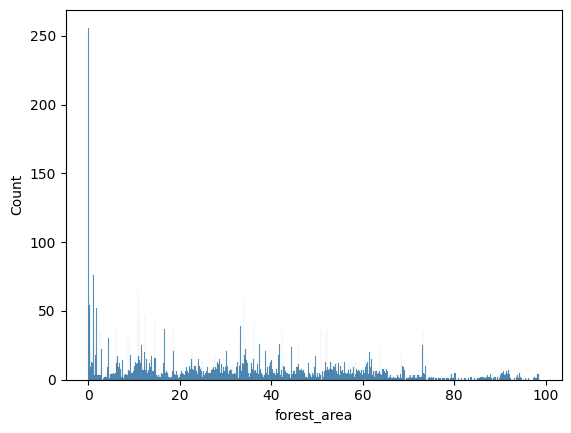

In [7]:
sns.histplot(data=melted_df, x='forest_area', binwidth=0.1)
plt.show()

We can see that we have countries that have 0 percent, which probably just is an indicator of not being able to record forest areas. 

In [8]:
#Making a list for all countries that have exactly 0.0 percent forest and removing those. 

zero_countries = melted_df.groupby('Country Code')['forest_area'].sum()

zero_countries = zero_countries[zero_countries == 0.0].index.tolist()

forest = melted_df[~melted_df['Country Code'].isin(zero_countries)]

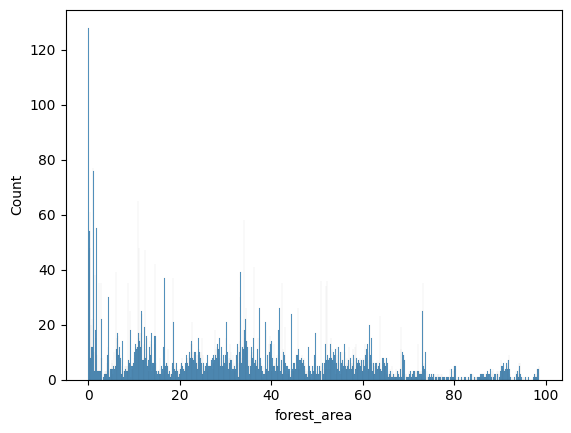

In [9]:
sns.histplot(data=forest, x='forest_area', binwidth=0.1)
plt.show()

We still do have a lot around 0, but no values of 0.0 anymore. Which means that the rest must be correct numbers.

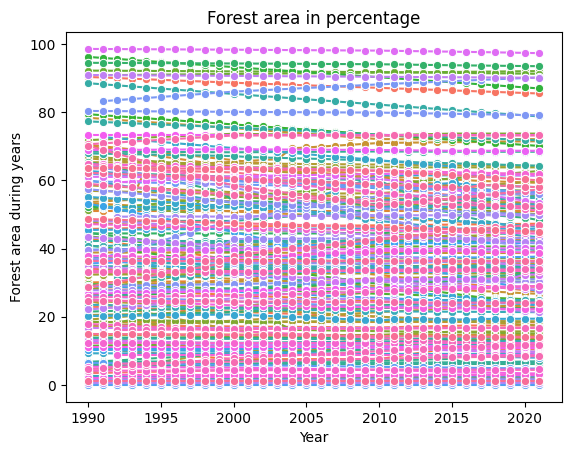

In [18]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
plt.title('Forest area in percentage')
plt.xlabel('Year')
plt.ylabel('Forest area during years')


# Show the plot
plt.show()

### Combine with predictor data 

In [12]:
#Read predictor file 

pred = pd.read_excel('git_data/predictor_data.xlsx')

print(pred)

                           Country Name Country Code  Year  Population, total  \
0                                 Aruba          ABW  1960            54608.0   
1           Africa Eastern and Southern          AFE  1960        130692579.0   
2                           Afghanistan          AFG  1960          8622466.0   
3            Africa Western and Central          AFW  1960         97256290.0   
4                                Angola          AGO  1960          5357195.0   
...                                 ...          ...   ...                ...   
17769                         Swaziland          SWZ  2021                NaN   
17770      Tanzania, United Republic of          TZA  2021                NaN   
17771                            Turkey          TUR  2021                NaN   
17772  Venezuela, Bolivarian Republic o          VEN  2021                NaN   
17773                             Yemen          YEM  2021                NaN   

       Land area (sq. km)  

In [40]:
#Renaming so no double names
forest = forest.rename(columns={'Country Name':'Country'})

#combining forest and pred data
forest_full = pd.merge(forest, pred, on = ['Year', 'Country Code'], how = 'inner')

#removing excess country column
forest_full = forest_full.drop(columns=['Country'])


Removing countries with all NaN in one column or half of the variables in the columns is NaN.

In [41]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
forest_full_filtered = forest_full[(forest_full['Year'] >= 1996) & (forest_full['Year'] <= 2020)]

#forest_full_filtered.info()

# Identify countries with NaN in forest_area (total of 8 countries)
countries_with_nan = forest_full_filtered[
    (forest_full_filtered['forest_area'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_nan)]

#Checkin how many countries were removed
#print(len(forest_full_filtered['Country Code'].unique()))
#print(len(forest_full['Country Code'].unique()))


In [42]:
# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = forest_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
forest_full_filtered = forest_full_filtered[forest_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

189
209


In [43]:
# Remove rows with 'Country Code' equal to 'NIU'
#forest_full_filtered = forest_full_filtered[forest_full_filtered['Country Code'] != 'NIU']

# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = forest_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
forest_full_filtered = forest_full_filtered[~forest_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

#Checking how many countries were removed
print(len(forest_full_filtered['Country Code'].unique()))
print(len(forest_full['Country Code'].unique()))

Countries removed using country code: ['ASM', 'EGY', 'PRI', 'IRN', 'GMB', 'BOL', 'STP', 'GUM', 'TZA', 'MKD', 'LCA', 'CIV', 'LBY', 'BHS', 'MDA', 'KNA', 'GRL', 'VIR', 'SVK', 'COG', 'ABW', 'LAO', 'YEM', 'CPV', 'CZE', 'VEN', 'TUR', 'VNM', 'SWZ', 'KOR', 'KGZ', 'FSM', 'VCT', 'CYM', 'LIE', 'PRK', 'BMU']
152
209


In [44]:
print(len(forest_full_filtered['Country Code'].unique()))
print(forest_full_filtered.isna().sum())

152
Country Code             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
Country Name             0
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                  24
WGI GE                  56
WGI RQ                  56
WGI RL                   1
WGI CC                  46
Education             1168
Innovation            1491
Social Inequality     2064
ICT                    760
Health                   0
dtype: int64


We end up with 152 countries, and the relevant predictors mostly have fewer than 60 NaN. Then we impute the data for each of the countries where at least half of the observations are not NaN.

In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = forest_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country Name', 'Indicator Name', 'Indicator Code', 'Year', 'forest_area', 'Education', 'Innovation', 'Social Inequality'
]

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
forest_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(forest_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [53]:
forest_full_imputed.isna().sum()

Country Code             0
Country Name             0
Indicator Name           0
Indicator Code           0
Year                     0
forest_area              0
Education             1168
Innovation            1491
Social Inequality     2064
Population, total        0
Land area (sq. km)       0
WGI VA                   0
WGI PS                   0
WGI GE                   0
WGI RQ                   0
WGI RL                   0
WGI CC                   0
ICT                      0
Health                   0
dtype: int64

In [54]:
forest_full_imputed = forest_full_imputed.drop(columns=['Indicator Name', 'Indicator Code', 'Education', 'Innovation', 'Social Inequality'])
forest_full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3344 entries, 0 to 3343
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        3344 non-null   object 
 1   Country Name        3344 non-null   object 
 2   Year                3344 non-null   float64
 3   forest_area         3344 non-null   float64
 4   Population, total   3344 non-null   float64
 5   Land area (sq. km)  3344 non-null   float64
 6   WGI VA              3344 non-null   float64
 7   WGI PS              3344 non-null   float64
 8   WGI GE              3344 non-null   float64
 9   WGI RQ              3344 non-null   float64
 10  WGI RL              3344 non-null   float64
 11  WGI CC              3344 non-null   float64
 12  ICT                 3344 non-null   float64
 13  Health              3344 non-null   float64
dtypes: float64(12), object(2)
memory usage: 365.9+ KB


Delaying the forest area variable.

In [55]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
forest_full_imputed['lagged_forest'] = pd.NA

#Iterating over each row
for i in range(len(forest_full_imputed)):
    country = forest_full_imputed.loc[i, 'Country Code']
    year = forest_full_imputed.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = forest_full_imputed[(forest_full_imputed['Country Code'] == country) & (forest_full_imputed['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        forest_full_imputed.loc[i, 'lagged_forest'] = lagged_row['forest_area'].values[0]

#Display the new dataframe 
display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,1.852782,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,Afghanistan,1998.0,1.852782,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,Afghanistan,2000.0,1.852782,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,Afghanistan,2002.0,1.852782,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,Afghanistan,2003.0,1.852782,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,45.570273,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,45.093912
3340,ZWE,Zimbabwe,2017.0,45.451183,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,45.332093,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,45.213002,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [51]:
#Checking if the lagged is correct 
print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 2000.0)]['forest_area'])

print(forest_full_imputed[(forest_full_imputed['Country Code'] == 'ZWE') & (forest_full_imputed['Year'] == 1996.0)]['lagged_forest'])

3324    47.475714
Name: forest_area, dtype: float64
3322    47.475714
Name: lagged_forest, dtype: object


In [56]:
forest_full_imputed['lagged_forest'] = pd.to_numeric(forest_full_imputed['lagged_forest'])
forest_full_imputed = forest_full_imputed.rename(columns={'Land area (sq. km)':'land_area'})
forest_full_imputed = forest_full_imputed.rename(columns={'Population, total':'population'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI VA':'WGI_va'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI GE':'WGI_ge'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RL':'WGI_rl'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI RQ':'WGI_rq'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI PS':'WGI_ps'})
forest_full_imputed = forest_full_imputed.rename(columns={'WGI CC':'WGI_cc'})
forest_full_imputed =forest_full_imputed.dropna()

display(forest_full_imputed)

,Country Code,Country Name,Year,forest_area,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,1.852782,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,Afghanistan,1998.0,1.852782,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,Afghanistan,2000.0,1.852782,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,Afghanistan,2002.0,1.852782,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,Afghanistan,2003.0,1.852782,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,46.046633,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,45.570273
3336,ZWE,Zimbabwe,2013.0,45.927543,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,45.451183
3337,ZWE,Zimbabwe,2014.0,45.808453,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,45.332093
3338,ZWE,Zimbabwe,2015.0,45.689363,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,45.213002


In [61]:
print(forest_full_imputed.isna().sum())
print(len(forest_full_imputed['Country Code'].unique()))

Country Code     0
Country Name     0
Year             0
forest_area      0
population       0
land_area        0
WGI_va           0
WGI_ps           0
WGI_ge           0
WGI_rq           0
WGI_rl           0
WGI_cc           0
ICT              0
Health           0
lagged_forest    0
dtype: int64
152


### Save combined clean data 

In [2]:
forest_full_imputed.to_csv('git_data/forest-modelling.csv', index=False)

NameError: name 'forest_full_imputed' is not defined

# Data exploration

In [3]:
#Load in cleaned data 
forest = pd.read_csv('git_data/forest-modelling.csv')

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   2736 non-null   object 
 1   Country Name   2736 non-null   object 
 2   Year           2736 non-null   float64
 3   forest_area    2736 non-null   float64
 4   population     2736 non-null   float64
 5   land_area      2736 non-null   float64
 6   WGI_va         2736 non-null   float64
 7   WGI_ps         2736 non-null   float64
 8   WGI_ge         2736 non-null   float64
 9   WGI_rq         2736 non-null   float64
 10  WGI_rl         2736 non-null   float64
 11  WGI_cc         2736 non-null   float64
 12  ICT            2736 non-null   float64
 13  Health         2736 non-null   float64
 14  lagged_forest  2736 non-null   float64
dtypes: float64(13), object(2)
memory usage: 320.8+ KB


# Modeling forest data 

In [2]:
import pandas as pd

In [3]:
forest = pd.read_csv(r'git_data\forest-modelling.csv')

forest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country Code   2736 non-null   object 
 1   Country Name   2736 non-null   object 
 2   Year           2736 non-null   float64
 3   forest_area    2736 non-null   float64
 4   population     2736 non-null   float64
 5   land_area      2736 non-null   float64
 6   WGI_va         2736 non-null   float64
 7   WGI_ps         2736 non-null   float64
 8   WGI_ge         2736 non-null   float64
 9   WGI_rq         2736 non-null   float64
 10  WGI_rl         2736 non-null   float64
 11  WGI_cc         2736 non-null   float64
 12  ICT            2736 non-null   float64
 13  Health         2736 non-null   float64
 14  lagged_forest  2736 non-null   float64
dtypes: float64(13), object(2)
memory usage: 320.8+ KB


In [9]:
print(forest.isna().sum())

Country Code     0
Country Name     0
Year             0
forest_area      0
population       0
land_area        0
WGI_va           0
WGI_ps           0
WGI_ge           0
WGI_rq           0
WGI_rl           0
WGI_cc           0
ICT              0
Health           0
lagged_forest    0
dtype: int64


In [47]:
forest = forest_full.drop(columns=['ICT', 'Innovation'])

forest = forest.dropna()
print(forest)

     Country Code                Indicator Name  Indicator Code    Year  \
1257          ALB  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1265          AUT  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1280          BRA  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1286          CAN  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
1288          CHL  Forest area (% of land area)  AG.LND.FRST.ZS  1996.0   
...           ...                           ...             ...     ...   
6813          SWE  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6821          THA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6827          TUN  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6834          URY  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   
6835          USA  Forest area (% of land area)  AG.LND.FRST.ZS  2021.0   

      forest_area   Country Name  Population, total  Land area (sq. km)  \
1257    28.361314       

In [49]:
countries_without_nans = forest.dropna(subset=forest.columns, how='any')['Country Code'].unique()

len(countries_without_nans)

134

In [50]:
len(forest['Country Code'].unique())

forest.describe()

,Year,forest_area,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Social Inequality
count,1228.000000,1228.000000,1.228000e+03,1.228000e+03,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000,1228.000000
mean,2011.052117,31.589070,5.926650e+07,1.067069e+06,0.384096,0.106379,0.425366,0.463525,0.319351,0.300858,52.597148,6.941775
std,6.346081,19.363088,1.928120e+08,2.713946e+06,0.913825,0.864469,0.935872,0.890138,0.999573,1.058701,25.656362,1.889426
min,1996.000000,0.045186,4.472800e+04,1.800000e+02,-1.833387,-2.810035,-2.336034,-2.242906,-1.976794,-1.759068,0.456960,1.600000
25%,2006.000000,13.053363,4.005037e+06,4.808000e+04,-0.233657,-0.472843,-0.348622,-0.245562,-0.537161,-0.562483,34.835217,5.700000
50%,2012.000000,31.474027,9.511978e+06,1.750200e+05,0.490304,0.207683,0.328050,0.472256,0.212978,0.038138,55.439854,7.100000
75%,2016.000000,45.014950,4.417752e+07,5.475570e+05,1.139616,0.802297,1.210805,1.216194,1.178231,1.197882,70.943386,8.400000
max,2021.000000,80.216075,1.411100e+09,1.638139e+07,1.800992,1.720112,2.347191,2.039989,2.124782,2.459118,150.201767,10.500000


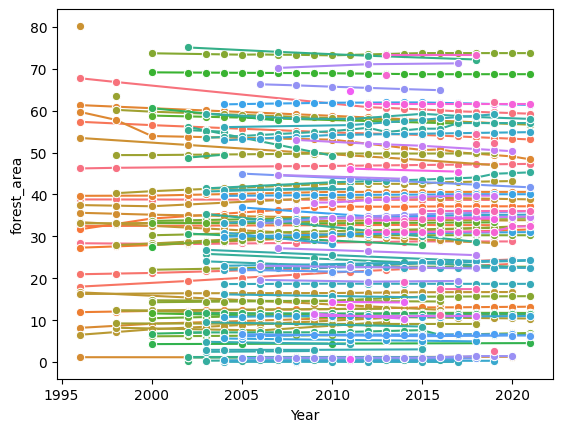

In [52]:
sns.lineplot(data=forest, x='Year', y='forest_area', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

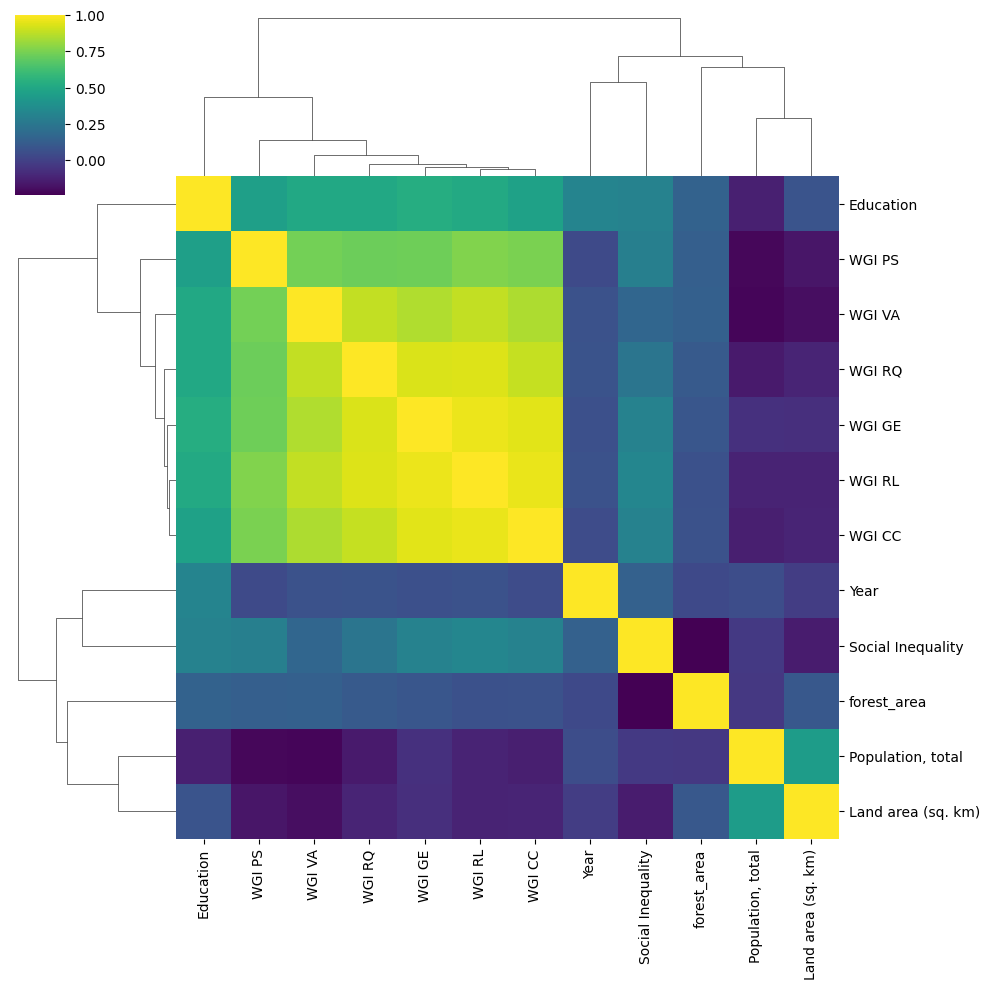

In [53]:
forest_num = forest[forest.select_dtypes(exclude=['object']).columns]

sns.clustermap(forest_num.corr(), cmap='viridis')
plt.show()

In [12]:
display(forest)

,Country Code,Country Name,Year,forest_area,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
0,AFG,Afghanistan,1996.0,1.852782,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,Afghanistan,1998.0,1.852782,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,Afghanistan,2000.0,1.852782,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,Afghanistan,2002.0,1.852782,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,Afghanistan,2003.0,1.852782,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,Zimbabwe,2012.0,46.046633,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,45.570273
2732,ZWE,Zimbabwe,2013.0,45.927543,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,45.451183
2733,ZWE,Zimbabwe,2014.0,45.808453,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,45.332093
2734,ZWE,Zimbabwe,2015.0,45.689363,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,45.213002


In [6]:
#Defining the features (X) and the target variable (y)
X = forest.drop(columns=['Country Name', 'lagged_forest', 'forest_area']) 
y = forest['lagged_forest'] 

#Defining the group variable (Country)
groups = forest['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [7]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 12) (1908,)
Validation set shape: (414, 12) (414,)
Test set shape: (414, 12) (414,)


In [8]:
display(X_train)
display(y_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969
2732,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198
2733,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720
2734,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355


0        1.852782
1        1.852782
2        1.852782
3        1.852782
4        1.852782
          ...    
2731    45.570273
2732    45.451183
2733    45.332093
2734    45.213002
2735    45.093912
Name: lagged_forest, Length: 1908, dtype: float64

## Baseline Median Dummy Model 

- **Data Preparation:**
  - Import necessary libraries for numerical computations and model evaluation.
  - Convert the 'lagged_ghg' column in the dataset (`ghg_model`) to numeric data type.
  - Define a function `detect_outliers` to identify outliers using the Interquartile Range (IQR) method within each group of data.
  - Apply the outlier detection function to group the data by 'Country Code' and identify outliers.
  - Print the total number of outliers and the number of outliers per country.
  
- **Data Splitting:**
  - Define features (`X`) and the target variable (`y`) by excluding certain columns from the dataset.
  - Define the grouping variable (`groups`) based on 'Country Code'.
  - Initialize a GroupShuffleSplit object (`gss_outer`) to split the data into training and test sets while preserving groups.
  - Split the data into training and test sets, and further split the test set into validation and test sets using nested GroupShuffleSplit objects.
  - Print the shapes of the training, validation, and test sets.

- **Model Evaluation:**
  - Initialize a list (`performances`) to store performance metrics.
  - For each data split (train, val, test):
    - Calculate the median of 'lagged_ghg' for each country in the current split.
    - Merge the median values back to the current data split.
    - Use the median 'lagged_ghg' as predictions for the baseline model.
    - Calculate performance metrics (MAE, RMSE, MAPE, R2) for the baseline model on the current data split and append them to the `performances` list.

- **Performance Visualization:**
  - Print the performance metrics (MAE, RMSE, MAPE, R2) for each model split.
  - Visualize the performance metrics using scatterplots sorted by RMSE, MAPE, MAE, and R2 for each model split.

In [42]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pickle as pkl
from math import sqrt
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_forest'].quantile(0.25)
    Q3 = group['lagged_forest'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_forest'] < lower_bound) | (group['lagged_forest'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = forest.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Print the outliers
#print("Outliers in 'lagged_ghg' per 'Country Code':")
#print(outliers)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')



Total number of outliers: 70

Number of outliers per 'Country Code':
Country Code
ARE    2
BGD    1
BGR    1
BLR    1
BRN    2
BTN    2
CYP    3
DEU    2
DJI    4
DZA    2
ERI    2
ESP    2
ETH    2
GEO    2
GHA    2
GRC    2
HRV    1
HUN    3
JPN    2
KEN    1
KWT    2
LTU    1
LVA    1
MAR    1
MDG    1
MLT    4
MNG    3
MUS    3
MYS    1
NLD    1
NPL    2
NZL    3
OMN    3
RUS    2
RWA    1
THA    2
dtype: int64
Number of countries with outliers: 36


In [27]:
#Defining the features (X) and the target variable (y)
X = forest.drop(columns=['Country Name', 'forest_area']) 
y = forest['lagged_forest'] 

#Defining the group variable (Country)
groups = forest['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [28]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 13) (1908,)
Validation set shape: (414, 13) (414,)
Test set shape: (414, 13) (414,)


In [29]:
display(X_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health,lagged_forest
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,1.852782
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,1.852782
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,1.852782
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,1.852782
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,1.852782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,45.570273
2732,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,45.451183
2733,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,45.332093
2734,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,45.213002


In [43]:
# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Calculate median lagged_ghg for each country in the current data split
    medians_split = x.groupby('Country Code')['lagged_forest'].median().reset_index()
    medians_split.columns = ['Country Code', 'median_lagged_forest']
    
    # Merge the median values back to the current data split
    x = x.merge(medians_split, on='Country Code', how='left')
    
    # Use the median_lagged_ghg as the prediction for the baseline model
    x['median_prediction'] = x['median_lagged_forest']
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': name,
        'split': nsplit,
        'mae': round(mae, 4),
        'rmse': round(rmse, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })


In [44]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  1.2843
MAE:  0.6214
MAPE:  0.025
R2:  0.9971


Model:  X_val
Split:  val
RMSE:  0.8233
MAE:  0.4791
MAPE:  0.0259
R2:  0.9988


Model:  X_test
Split:  test
RMSE:  1.0172
MAE:  0.5694
MAPE:  0.0223
R2:  0.9986




In [45]:
perf_df = pd.DataFrame(performances)

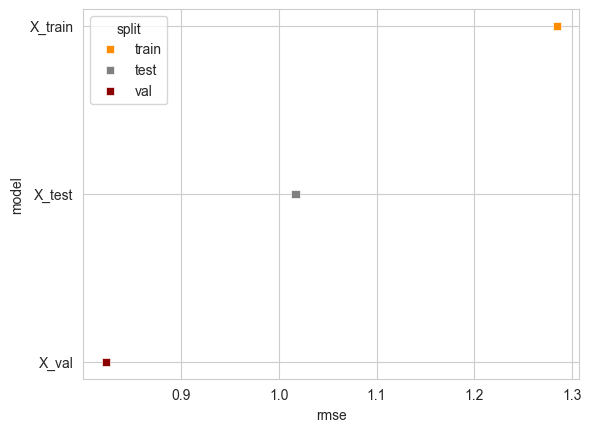

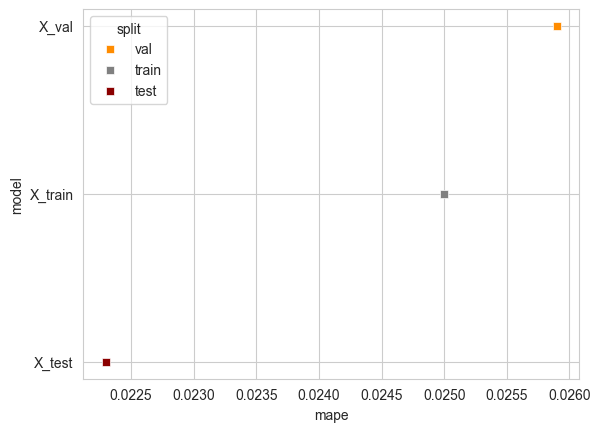

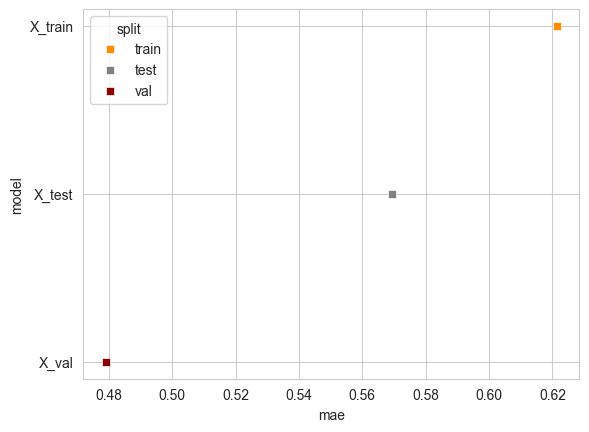

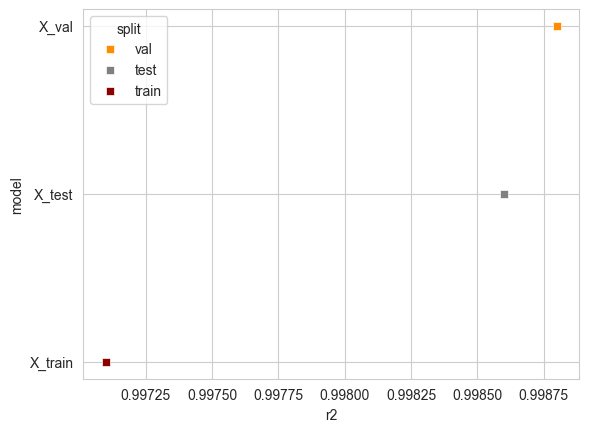

In [46]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [12]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combined MERF Model

In [22]:
# Initialize a list to store performance metrics
performances = []

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 1692.2841634387175 at iteration 1.
INFO     [merf.py:307] Training GLL is 1780.0357097696037 at iteration 2.
INFO     [merf.py:307] Training GLL is 1548.073071563484 at iteration 3.
INFO     [merf.py:307] Training GLL is 1443.3337372152603 at iteration 4.
INFO     [merf.py:307] Training GLL is 1437.6813259778323 at iteration 5.
INFO     [merf.py:307] Training GLL is 1142.5261591492224 at iteration 6.
INFO     [merf.py:307] Training GLL is 1032.2728739038305 at iteration 7.
INFO     [merf.py:307] Training GLL is 909.2807199267091 at iteration 8.
INFO     [merf.py:307] Training GLL is 1038.7170271294824 at iteration 9.
INFO     [merf.py:307] Training GLL is 792.9163470889683 at iteration 10.
INFO     [merf.py:307] Training GLL is 812.1774744322184 at iteration 11.
INFO     [merf.py:307] Training GLL is 817.2797229983095 at iteration 12.
INFO     [merf.py:307] Training GLL is 693.7734952062272 at iteration 13.
INFO     [merf.py:307] Training GLL is 6

In [23]:
print(performances)

[{'model': 'X_train', 'split': 'train', 'rmse': 0.7963, 'mae': 0.3727, 'mape': 0.396, 'r2': 0.9989}, {'model': 'X_val', 'split': 'val', 'rmse': 27.952, 'mae': 22.6252, 'mape': 6.2751, 'r2': -0.3958}, {'model': 'X_test', 'split': 'test', 'rmse': 27.036, 'mae': 21.7445, 'mape': 19.334, 'r2': 0.007}]


In [24]:
perf_df = pd.DataFrame(performances)

In [25]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.7963
MAE:  0.3727
MAPE:  0.396
R2:  0.9989


Model:  X_val
Split:  val
RMSE:  27.952
MAE:  22.6252
MAPE:  6.2751
R2:  -0.3958


Model:  X_test
Split:  test
RMSE:  27.036
MAE:  21.7445
MAPE:  19.334
R2:  0.007




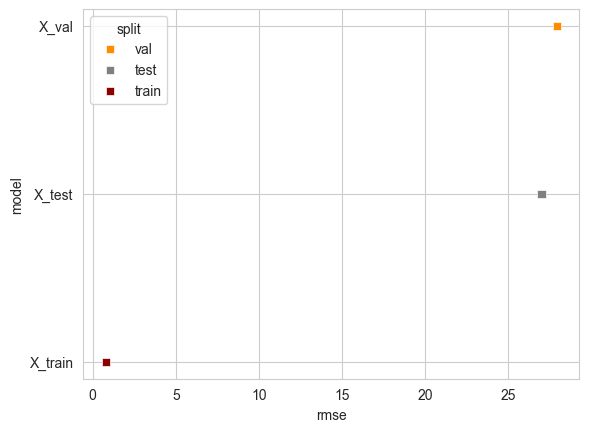

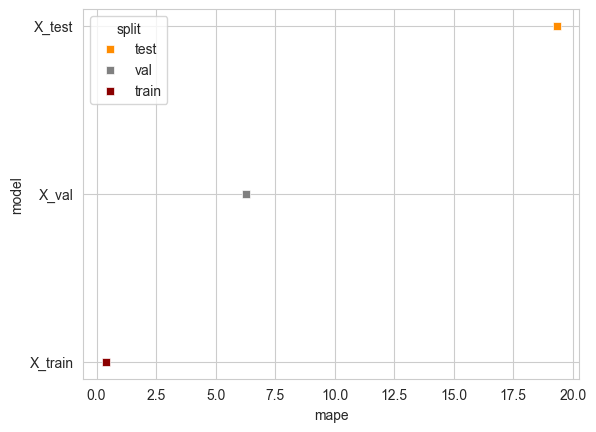

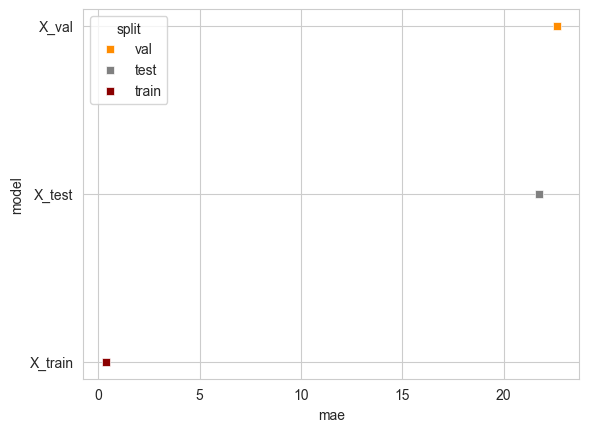

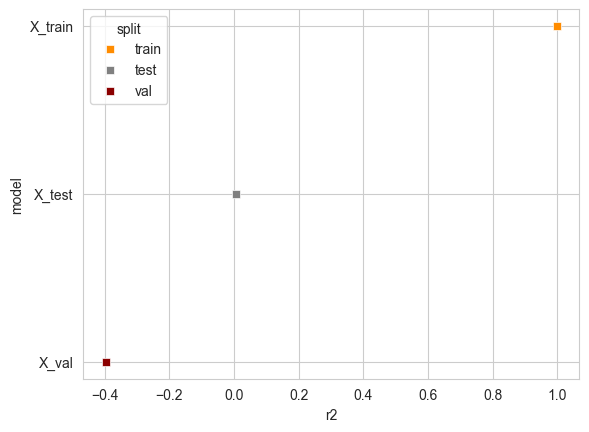

In [26]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

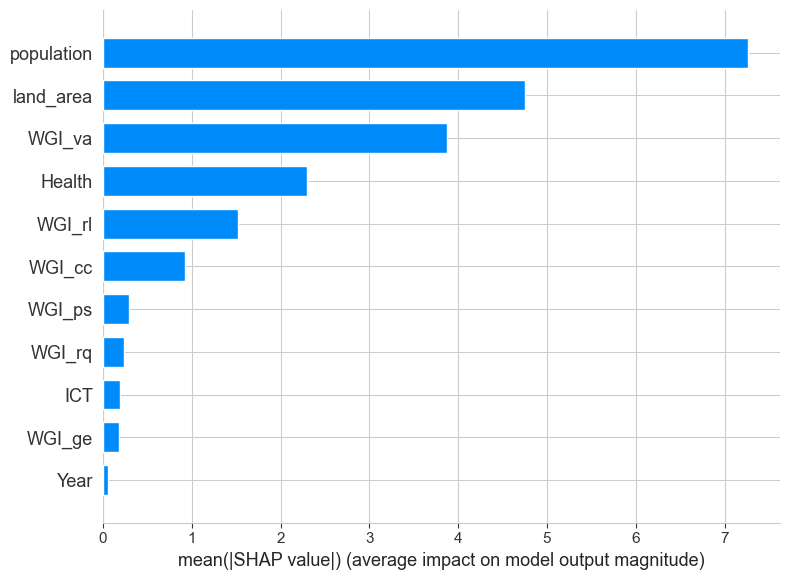

In [27]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [28]:
display(X_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969
2732,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198
2733,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720
2734,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355


In [30]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_va', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 1444.93289664765 at iteration 1.
INFO     [merf.py:307] Training GLL is 1255.451199270033 at iteration 2.
INFO     [merf.py:307] Training GLL is 1176.4448910890308 at iteration 3.
INFO     [merf.py:307] Training GLL is 1050.2484733910492 at iteration 4.
INFO     [merf.py:307] Training GLL is 745.2306318037978 at iteration 5.
INFO     [merf.py:307] Training GLL is 653.1043393175781 at iteration 6.
INFO     [merf.py:307] Training GLL is 553.5580222929425 at iteration 7.
INFO     [merf.py:307] Training GLL is 256.43423604797334 at iteration 8.
INFO     [merf.py:307] Training GLL is 164.81128244013152 at iteration 9.
INFO     [merf.py:307] Training GLL is 56.40396290227949 at iteration 10.
INFO     [merf.py:307] Training GLL is -140.0035014218298 at iteration 11.
INFO     [merf.py:307] Training GLL is -251.55566072950185 at iteration 12.
INFO     [merf.py:307] Training GLL is -349.4492106848562 at iteration 13.
INFO     [merf.py:307] Training GLL is -

In [31]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.5223
MAE:  0.2851
MAPE:  0.5727
R2:  0.9995


Model:  X_val
Split:  val
RMSE:  30.2894
MAE:  24.5663
MAPE:  6.6012
R2:  -0.639


Model:  X_test
Split:  test
RMSE:  25.3115
MAE:  19.3656
MAPE:  18.3776
R2:  0.1296




In [32]:
perf_df = pd.DataFrame(performances)

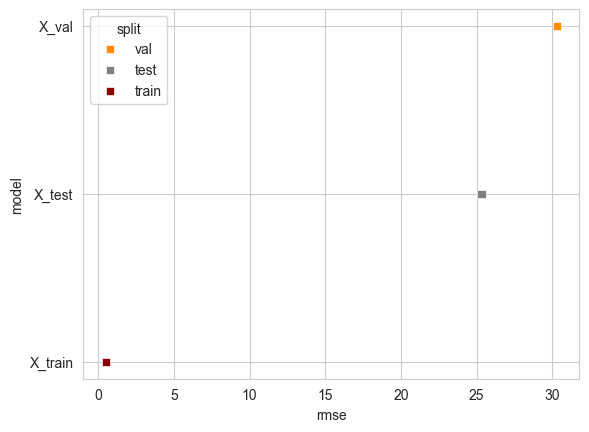

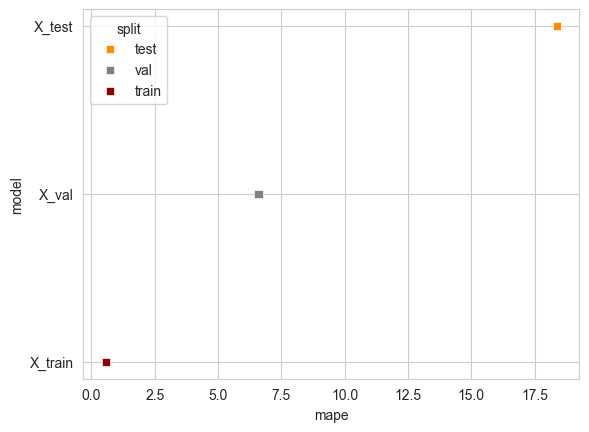

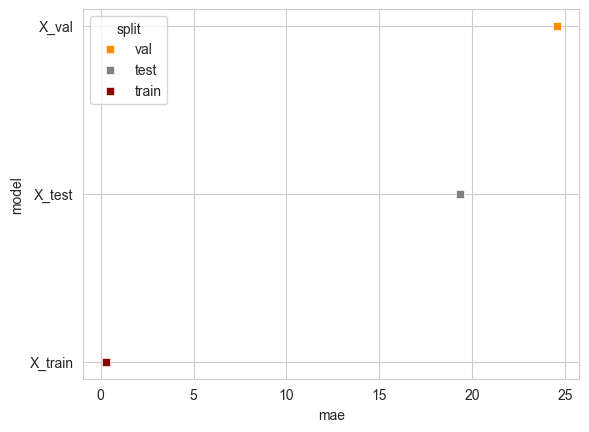

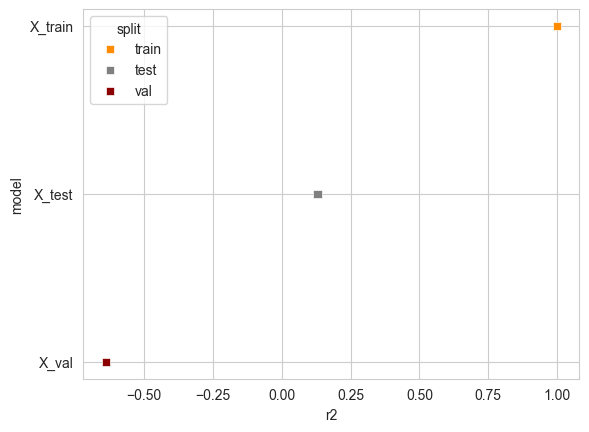

In [33]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

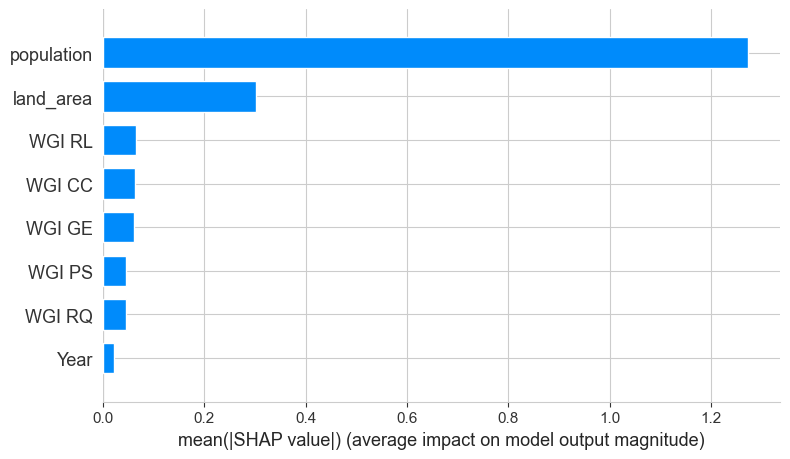

In [ ]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [ ]:
display(y_train)

,Country Code,Year,population,land_area,WGI_va,WGI_ps,WGI_ge,WGI_rq,WGI_rl,WGI_cc,ICT,Health
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969
2732,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198
2733,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720
2734,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355


In [13]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Social Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI_ps','WGI_ge','WGI_rq','WGI_rl','WGI_cc'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is 1059.1101163207115 at iteration 1.
INFO     [merf.py:307] Training GLL is 1178.0529644812736 at iteration 2.
INFO     [merf.py:307] Training GLL is 1135.9145064290044 at iteration 3.
INFO     [merf.py:307] Training GLL is 1020.7299882073222 at iteration 4.
INFO     [merf.py:307] Training GLL is 858.614802110016 at iteration 5.
INFO     [merf.py:307] Training GLL is 819.0826323848765 at iteration 6.
INFO     [merf.py:307] Training GLL is 817.7150360994385 at iteration 7.
INFO     [merf.py:307] Training GLL is 845.6059629762383 at iteration 8.
INFO     [merf.py:307] Training GLL is 479.17536104720625 at iteration 9.
INFO     [merf.py:307] Training GLL is 706.1104099394327 at iteration 10.
INFO     [merf.py:307] Training GLL is 427.5316682253884 at iteration 11.
INFO     [merf.py:307] Training GLL is 608.7493189266054 at iteration 12.
INFO     [merf.py:307] Training GLL is 470.9545300783174 at iteration 13.
INFO     [merf.py:307] Training GLL is 323.

In [36]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.7898
MAE:  0.3413
MAPE:  0.3586
R2:  0.9989


Model:  X_val
Split:  val
RMSE:  27.155
MAE:  22.2307
MAPE:  6.6456
R2:  -0.3173


Model:  X_test
Split:  test
RMSE:  26.6006
MAE:  21.2291
MAPE:  19.0498
R2:  0.0387




In [37]:
perf_df = pd.DataFrame(performances)

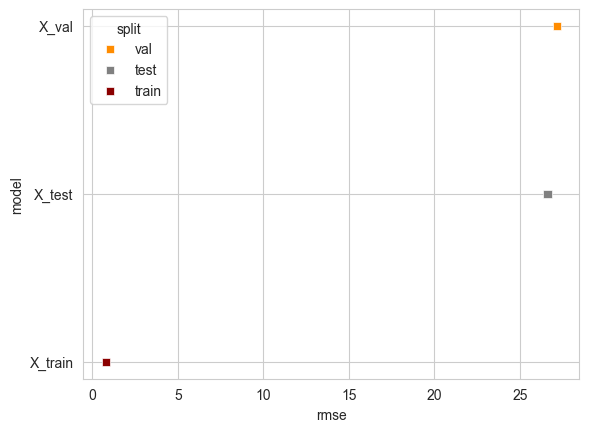

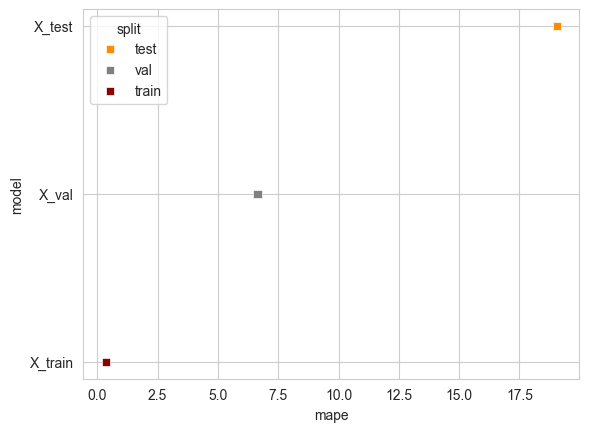

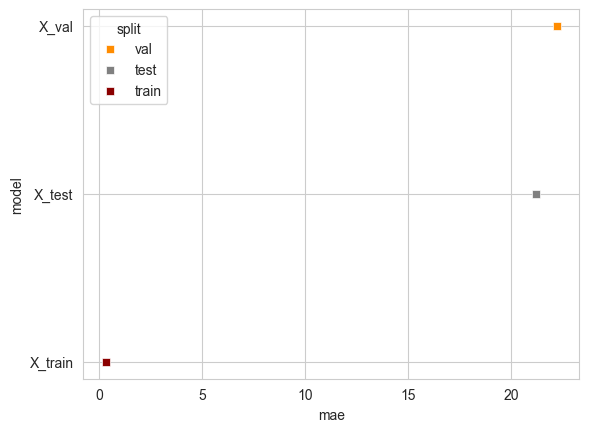

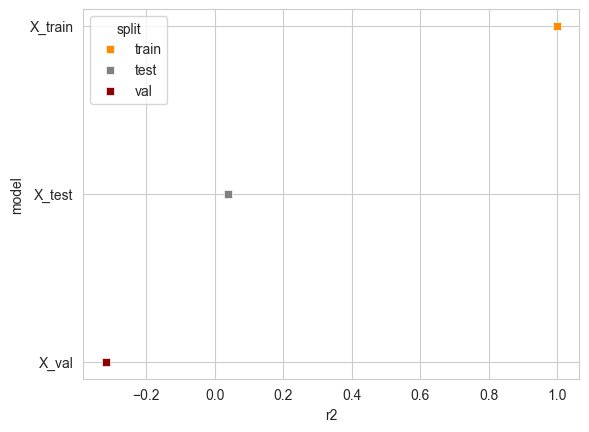

In [38]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

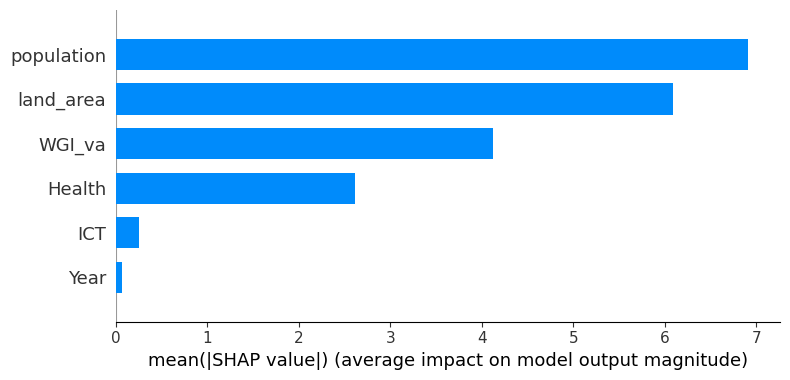

In [14]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

In [15]:
# Find the highest and lowest lagged_forest scores
all_scores = np.concatenate([y_train, y_val, y_test])

highest_score = np.max(all_scores)
lowest_score = np.min(all_scores)

print(f'Highest lagged_forest score: {highest_score}')
print(f'Lowest lagged_forest score: {lowest_score}')

Highest lagged_forest score: 98.3389102564103
Lowest lagged_forest score: 0.0080775444264943
